In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 1.) Dataset

In [2]:
# Baca Datasets
data = pd.read_csv("/content/tweet.csv")

In [3]:
data.head()

,Unnamed: 0,sentimen,tweet
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1815 non-null   int64 
 1   sentimen    1815 non-null   object
 2   tweet       1815 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.7+ KB


In [5]:
data.isnull().sum()

Unnamed: 0    0
sentimen      0
tweet         0
dtype: int64

In [6]:
data['sentimen'].value_counts()

positif    612
netral     607
negatif    596
Name: sentimen, dtype: int64

# 2.) Natural Language Text Preprocessing

## Text Cleaning

### Stopwords, Punctuation, Case Folding

In [7]:
import re
import string
import pandas as pd

def clean_text(text):
    # Menghapus username Twitter (@username)
    text = re.sub(r'@\w+', '', text)

    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Menghapus karakter non-alfanumerik dan tanda baca
    text = re.sub(r'[^\w\s]', '', text)

    # Menghapus karakter berulang
    text = re.sub(r'(.)\1+', r'\1\1', text)

    # Mengubah ke lowercase
    text = text.lower()

    return text

def remove(tweet):
    # Remove mention
    tweet = re.sub("@[A-Za-z0-9_]+", "", tweet)
    # Remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # Remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'^rt[\s]+', '', tweet)
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'^https[\s]+', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'%', '', tweet)
    # Remove commas
    tweet = re.sub(r',', '', tweet)
    # Remove numbers
    tweet = re.sub('[0-9]+', '', tweet)
    tweet = re.sub(r':', '', tweet)
    # Remove space
    tweet = tweet.strip()
    # Remove double space}
    tweet = re.sub('\s+', ' ', tweet)
    # Menghapus angka
    tweet = re.sub(r'\d+', '', tweet)

    # Menghapus tanda baca
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Cleaning text
    cleaned_tweet = clean_text(tweet)

    return cleaned_tweet

# Menerapkan fungsi remove dan clean_text pada kolom 'tweet' dan menyimpan hasilnya dalam kolom 'cleaning_data'
data['tweet_clean'] = data['tweet'].apply(lambda x: remove(x.lower()))

# Menampilkan hasil
print(data['tweet_clean'])

0       kata indonesia tidak dihargai bangsa asing ber...
1       batuan langka tasbih jokowi hadiah dari habib ...
2       di era jokowi ekonomi indonesia semakin baik i...
3       bagi sumatera selatan asian games berdampak pd...
4       negara kita ngutang buat bngun infrastruktur y...
                              ...                        
1810    negarawan sejati sll bangga dan mengedepankan ...
1811     hrs ceramah di damai indonesiaku  perekonomia...
1812    mari bangun bangsa dgn mendukung perekonomian ...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_clean, Length: 1815, dtype: object


## Stopword Removal

In [8]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### Stopword Tradisional

In [9]:
import re
import pandas as pd

def remove_stopwords(text):
    stopwords = ['yg','ðŸ','ðÿœ',"yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah']  # Ganti dengan stopwords tradisional sesuai kebutuhan

    # Menghapus karakter non-alfabet dan mengubah teks menjadi huruf kecil
    processed_text = re.sub(r'[^a-zA-Z]', ' ', text.lower())

    # Memisahkan kata-kata dalam teks
    words = processed_text.split()

    # Menghapus stopwords dari teks
    filtered_words = [word for word in words if word not in stopwords]

    # Menggabungkan kembali kata-kata yang telah di-filter
    filtered_text = ' '.join(filtered_words)

    return filtered_text

 #Menerapkan fungsi remove_stopwords pada kolom 'tweet_clean'
filtered_text = data['tweet_clean'].apply(remove_stopwords)

 #Menampilkan DataFrame hasil
print(filtered_text)


0       kata indonesia tidak dihargai bangsa asing ber...
1       batuan langka tasbih jokowi hadiah dari habib ...
2       di era jokowi ekonomi indonesia semakin baik i...
3       bagi sumatera selatan asian games berdampak pd...
4       negara kita ngutang buat bngun infrastruktur y...
                              ...                        
1810    negarawan sejati sll bangga dan mengedepankan ...
1811    hrs ceramah di damai indonesiaku perekonomian ...
1812    mari bangun bangsa mendukung perekonomian nega...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_clean, Length: 1815, dtype: object


### Stopword Sastrawi

In [10]:
!pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import re

def preprocess_text(text):
    # Buat instance dari StopWordRemoverFactory
    factory = StopWordRemoverFactory()
    stopword_remover = factory.create_stop_word_remover()

    # Menghapus karakter non-alfanumerik dan mengubah ke huruf kecil
    text = re.sub(r'\W+', ' ', text.lower())

    # Menghapus stopwords dari teks menggunakan Sastrawi
    text_tanpa_stopword = stopword_remover.remove(text)

    return text_tanpa_stopword

data['tweet_sw'] =filtered_text.apply(preprocess_text)

print(data['tweet_sw'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.0 MB/s eta 0:00:00
0       kata indonesia dihargai bangsa asing berita pa...
1       batuan langka tasbih jokowi hadiah habib luthf...
2       era jokowi ekonomi indonesia semakin baik indo...
3       sumatera selatan asian games berdampak pd ekon...
4       negara ngutang buat bngun infrastruktur udah d...
                              ...                        
1810    negarawan sejati sll bangga mengedepankan harg...
1811    hrs ceramah damai indonesiaku perekonomian mak...
1812    bangun bangsa mendukung perekonomian negara be...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_sw, Length: 1815, dtype: object


## Text Normalization

### Lemmazation

In [11]:
import spacy
nlp = spacy.load('en_core_web_sm')

def lemmatization (text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)
data['tweet_clean'] = data['tweet_sw'].apply(lemmatization)

In [12]:
data['tweet_clean']

0       kata indonesia dihargai bangsa ase berita past...
1       batuan langka tasbih jokowi hadiah habib luthf...
2       era jokowi ekonomi indonesia semakin baik indo...
3       sumatera selatan asian game berdampak pd ekono...
4       negara ngutang buat bngun infrastruktur udah d...
                              ...                        
1810    negarawan sejati sll bangga mengedepankan harg...
1811    hrs ceramah damai indonesiaku perekonomian mak...
1812    bangun bangsa mendukung perekonomian negara be...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_clean, Length: 1815, dtype: object

## Text Tokenization

### Word Tokenization

In [13]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Fungsi untuk tokenisasi kata
def tokenize_words(text):
    words = word_tokenize(text)
    return words

# Tokenisasi kata
data['tweet_token_words'] = data['tweet_clean'].apply(tokenize_words)
print("\nTokenisasi kata:")
print(data['tweet_token_words'])


Tokenisasi kata:
0       [kata, indonesia, dihargai, bangsa, ase, berit...
1       [batuan, langka, tasbih, jokowi, hadiah, habib...
2       [era, jokowi, ekonomi, indonesia, semakin, bai...
3       [sumatera, selatan, asian, game, berdampak, pd...
4       [negara, ngutang, buat, bngun, infrastruktur, ...
                              ...                        
1810    [negarawan, sejati, sll, bangga, mengedepankan...
1811    [hrs, ceramah, damai, indonesiaku, perekonomia...
1812    [bangun, bangsa, mendukung, perekonomian, nega...
1813    [bantu, majukan, perekonomian, bangsa, bersama...
1814    [pak, mengubah, cara, pandang, ekonomi, kini, ...
Name: tweet_token_words, Length: 1815, dtype: object


### Sentence Tokenization

In [14]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Fungsi untuk tokenisasi kalimat
def tokenize_sentences(text):
    sentences = sent_tokenize(text)
    return sentences

# Tokenisasi kalimat
data['tweet_token_sentences'] = data['tweet_clean'].apply(tokenize_sentences)
print("Tokenisasi kalimat:")
print(data['tweet_token_sentences'])

Tokenisasi kalimat:
0       [kata indonesia dihargai bangsa ase berita pas...
1       [batuan langka tasbih jokowi hadiah habib luth...
2       [era jokowi ekonomi indonesia semakin baik ind...
3       [sumatera selatan asian game berdampak pd ekon...
4       [negara ngutang buat bngun infrastruktur udah ...
                              ...                        
1810    [negarawan sejati sll bangga mengedepankan har...
1811    [hrs ceramah damai indonesiaku perekonomian ma...
1812    [bangun bangsa mendukung perekonomian negara b...
1813    [bantu majukan perekonomian bangsa bersama pak...
1814    [pak mengubah cara pandang ekonomi kini semua ...
Name: tweet_token_sentences, Length: 1815, dtype: object


## Word2Vec

### CBOW

In [15]:
import gensim
from gensim.models import Word2Vec

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [16]:
clean_data = data['tweet_clean'].apply(gensim.utils.simple_preprocess)

In [17]:
w2v_model = Word2Vec(vector_size=W2V_SIZE,
                     window=W2V_WINDOW,
                     min_count=W2V_MIN_COUNT,
                     workers=8)

In [18]:
w2v_model.build_vocab(clean_data)

In [19]:
words = list(w2v_model.wv.key_to_index.keys())
vocab_size = len(words)
print("Vocab size:", vocab_size)

Vocab size: 599


In [20]:
%%time
w2v_model.train(clean_data, total_examples=len(clean_data), epochs=W2V_EPOCH)

CPU times: user 2.18 s, sys: 47.6 ms, total: 2.22 s
Wall time: 2.24 s


(485679, 1029728)

In [21]:
# Membuat objek Word2Vec (contoh)
sentences = [tweet.split() for tweet in data['tweet_clean']]
w2v_model = Word2Vec(sentences=sentences, min_count=1)

# Membuat kolom baru di DataFrame untuk menampung hasil append
data['tweet_w2v_model'] = data['tweet_clean'].apply(lambda x: w2v_model.wv[x.split()[0]] if len(x.split()) > 0 else [])

# Menampilkan DataFrame
print("tweet_w2v_model kalimat:")
print(data['tweet_w2v_model'])

tweet_w2v_model kalimat:
0       [-0.031047378, 0.108620666, 0.06571932, 0.0231...
1       [0.0012729826, 0.003569824, -0.003325973, 0.00...
2       [-0.032167733, 0.10593001, 0.0747535, 0.035609...
3       [-0.0008489212, 0.019022403, 0.020040477, -0.0...
4       [-0.06795244, 0.2820766, 0.19849297, 0.0710923...
                              ...                        
1810    [0.0012561973, -0.0005412329, 0.0013283701, 0....
1811    [-0.004023369, 0.06357584, 0.036334317, 0.0261...
1812    [-0.005980149, 0.053624652, 0.03813893, 0.0111...
1813    [-0.0022149968, 0.009161551, 0.0096154995, -0....
1814    [-0.0837237, 0.33829498, 0.21434599, 0.0880245...
Name: tweet_w2v_model, Length: 1815, dtype: object


In [22]:
similar_words = w2v_model.wv.most_similar("ekonomi")
similar_words

[('rakyat', 0.9996903538703918),
 ('jokowi', 0.9996380805969238),
 ('indonesia', 0.9995267987251282),
 ('harga', 0.9994871020317078),
 ('pak', 0.9994824528694153),
 ('negara', 0.999480128288269),
 ('prabowo', 0.9994533061981201),
 ('debat', 0.9994401931762695),
 ('orang', 0.9994269013404846),
 ('mau', 0.9994230270385742)]

## EDA

### Distribusi Dari Review per Sentimen






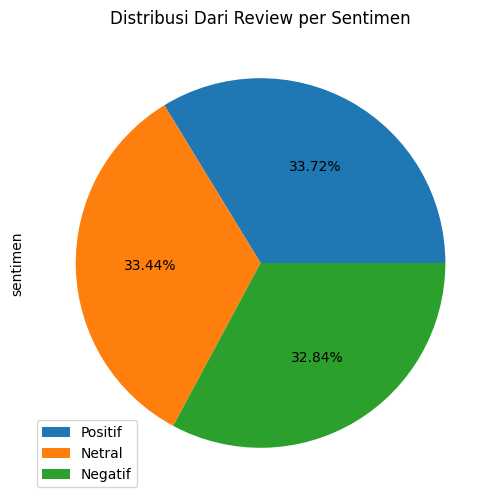

In [23]:
import matplotlib.pyplot as plt

data['sentimen'].value_counts().plot.pie(figsize=(6,6),title="Distribusi Dari Review per Sentimen",labels=['','',''],autopct='%1.2f%%')
labels=["Positif","Netral","Negatif"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

### Visualizing Word Clouds

In [24]:
from wordcloud import WordCloud

In [25]:
data_negatif = data[data['sentimen'] == "positif"]
data_positif = data[data['sentimen'] == "negatif"]
data_netral = data[data['sentimen'] == "netral"]

# Menggabungkan semua list menjadi satu list tunggal
all_frekuensi_list = [word for sublist in data['tweet_token_words'] for word in sublist]
negative_list = [word for sublist in data_negatif['tweet_token_words'] for word in sublist]
positive_list = [word for sublist in data_positif['tweet_token_words'] for word in sublist]
netral_list = [word for sublist in data_netral['tweet_token_words'] for word in sublist]

filtered_all_frekuensi = " ".join(all_frekuensi_list)  # Mengubah list menjadi string
filtered_all_frekuensi = filtered_all_frekuensi.lower()

filtered_negative = " ".join(negative_list)  # Mengubah list menjadi string
filtered_negative = filtered_negative.lower()

filtered_positive = " ".join(positive_list)  # Mengubah list menjadi string
filtered_positive = filtered_positive.lower()

filtered_neutral = " ".join(netral_list)  # Mengubah list menjadi string
filtered_neutral = filtered_neutral.lower()


#### Word Cloud : Frekuensi Semua Ulasan

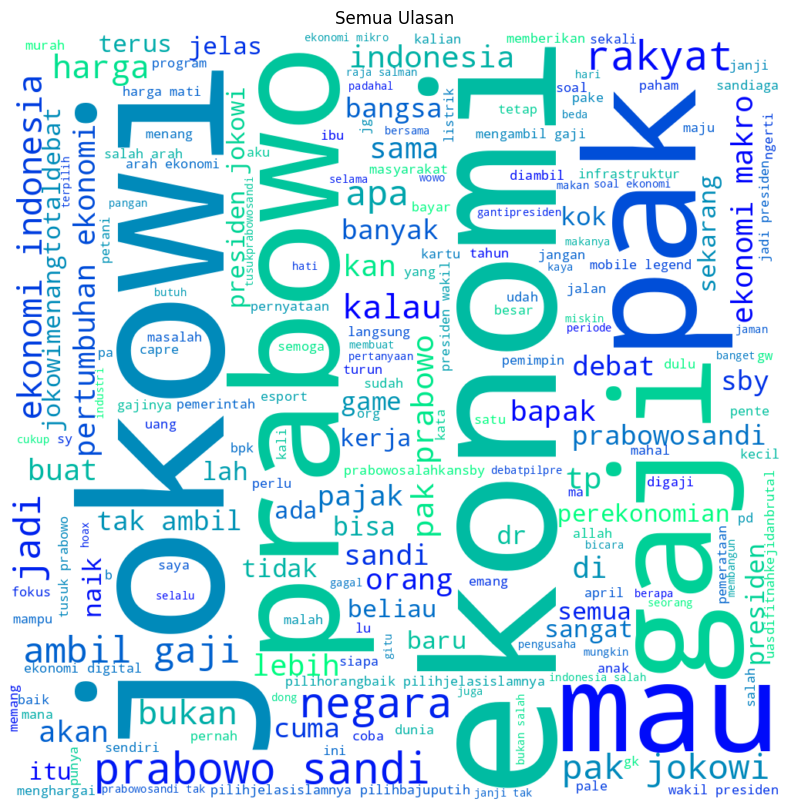

In [26]:
# Visualisasi frekuensi kemunculan kata

wordcloud = WordCloud(colormap='winter', width=1000, height=1000, mode='RGBA', background_color='white').generate(filtered_all_frekuensi)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Semua Ulasan")
plt.margins(x=0, y=0)
plt.show()

#### Word Cloud : Positive

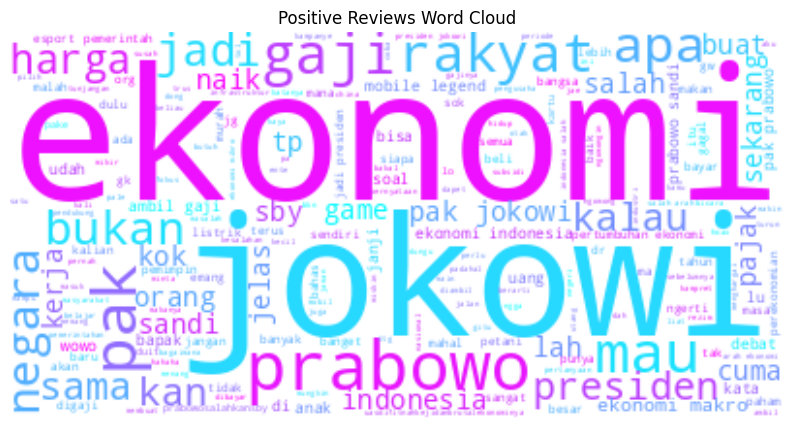

In [27]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="cool").generate(filtered_positive)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Positive Reviews Word Cloud")
plt.show()

#### Word Cloud : Negatif

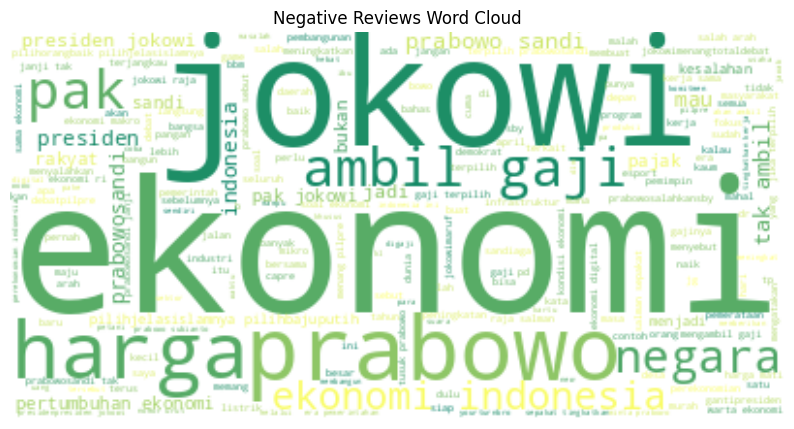

In [28]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="summer").generate(filtered_neutral)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Negative Reviews Word Cloud")
plt.show()

#### Word Cloud : Netral

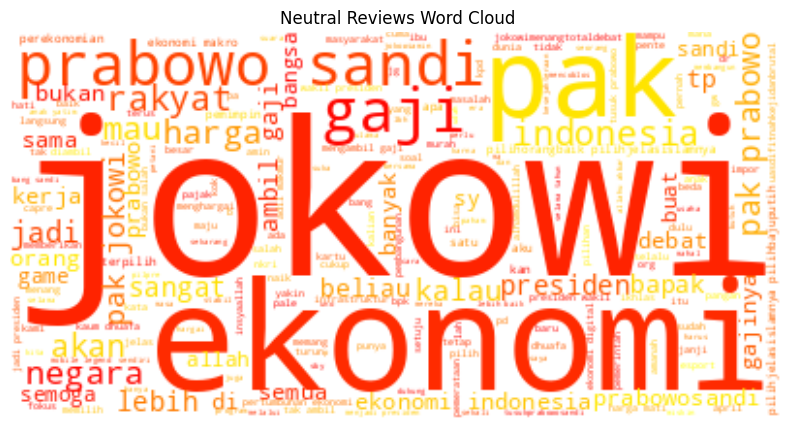

In [29]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="autumn").generate(filtered_negative)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Neutral Reviews Word Cloud")
plt.show()

## Data Final

In [30]:
data.head()

,Unnamed: 0,sentimen,tweet,tweet_clean,tweet_sw,tweet_token_words,tweet_token_sentences,tweet_w2v_model
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,kata indonesia dihargai bangsa ase berita past...,kata indonesia dihargai bangsa asing berita pa...,"[kata, indonesia, dihargai, bangsa, ase, berit...",[kata indonesia dihargai bangsa ase berita pas...,"[-0.031047378, 0.108620666, 0.06571932, 0.0231..."
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...,batuan langka tasbih jokowi hadiah habib luthf...,"[batuan, langka, tasbih, jokowi, hadiah, habib...",[batuan langka tasbih jokowi hadiah habib luth...,"[0.0012729826, 0.003569824, -0.003325973, 0.00..."
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia semakin baik indo...,era jokowi ekonomi indonesia semakin baik indo...,"[era, jokowi, ekonomi, indonesia, semakin, bai...",[era jokowi ekonomi indonesia semakin baik ind...,"[-0.032167733, 0.10593001, 0.0747535, 0.035609..."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian game berdampak pd ekono...,sumatera selatan asian games berdampak pd ekon...,"[sumatera, selatan, asian, game, berdampak, pd...",[sumatera selatan asian game berdampak pd ekon...,"[-0.0008489212, 0.019022403, 0.020040477, -0.0..."
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...,negara ngutang buat bngun infrastruktur udah d...,negara ngutang buat bngun infrastruktur udah d...,"[negara, ngutang, buat, bngun, infrastruktur, ...",[negara ngutang buat bngun infrastruktur udah ...,"[-0.06795244, 0.2820766, 0.19849297, 0.0710923..."


# 3.) Data Modeling

## Split Data Train dan Test

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Menggabungkan teks dalam list menjadi satu string
corpus = [' '.join(tokens) for tokens in data['tweet_token_sentences']]

# Feature extraction
vectorizer = TfidfVectorizer()
X_rf = vectorizer.fit_transform(corpus)
y_rf = data['sentimen']

In [32]:
# Map label to integers
label_mapping = {'positif': 0, 'negatif': 1, 'netral': 2}
y_rf = y_rf.map(label_mapping)

In [33]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

## Algoritma : Random Forest

In [34]:
# Define hyperparameters for tuning

#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 10, 20],
#    'max_features': ['auto', 'sqrt'],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4]}

# GridSearchCV for hyperparameter tuning
#grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
#grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
#best_params = grid_search.best_params_
#best_model = grid_search.best_estimator_

# Predict using the best model
#y_pred = best_model.predict(X_test)

In [35]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Random Forest Classifier
modle_rf = RandomForestClassifier(max_depth = 20, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 5, n_estimators = 300)
modle_rf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=20, max_features='auto', min_samples_split=5,
                       n_estimators=300)

In [36]:
# Predict
y_pred = modle_rf.predict(X_test)
print(y_pred)

[1 0 0 0 1 0 2 2 2 1 1 1 0 2 0 1 2 0 0 0 0 1 1 2 0 0 1 1 2 1 1 1 1 1 2 0 1
 0 1 2 2 1 2 2 0 1 0 1 0 0 1 1 0 2 1 1 1 2 1 0 0 1 2 1 1 2 0 1 1 0 1 1 0 2
 2 0 2 0 1 2 1 2 0 1 2 1 2 1 1 2 1 1 2 0 2 2 0 1 0 1 2 2 0 2 2 1 0 0 0 2 2
 2 0 2 1 1 1 2 1 1 1 1 2 2 2 2 1 2 0 1 1 2 0 1 0 0 2 1 1 2 1 1 2 1 0 2 2 0
 0 0 1 2 0 2 2 0 2 0 1 2 2 1 1 1 2 2 2 0 1 0 1 2 0 2 1 2 2 1 0 0 1 2 0 1 2
 0 2 2 0 1 2 1 2 2 2 0 1 1 1 1 1 2 2 1 1 1 2 0 1 0 1 2 1 2 0 2 0 0 2 2 1 0
 1 1 1 2 2 0 1 0 1 2 1 2 2 1 1 2 2 1 2 2 2 1 0 0 2 0 0 2 0 2 1 2 1 2 1 1 2
 1 1 0 2 1 0 2 0 1 0 1 1 2 1 2 1 1 0 0 2 1 1 1 1 1 2 0 2 2 1 1 2 0 1 0 1 2
 2 1 1 1 0 1 0 1 0 2 1 0 2 0 2 2 2 2 2 1 1 1 2 1 1 2 0 2 2 1 2 0 1 1 0 0 0
 2 1 2 1 1 0 2 1 1 1 1 1 1 1 0 1 2 1 1 0 0 1 1 2 2 1 2 2 0 2 1 2 1 0 1 1 2
 2 1 1 1 1 0 1 2 0 1 1 0 1 2 2 2 0 1 2 1 0 2 2 2 1 1 0 1 0 2 2 0 1 1 0 1 1
 1 2 1 2 1 0 2 1 2 1 0 0 2 1 1 0 1 1 1 2 1 0 0 1 0 2 1 2 0 1 0 2 0 0 2 0 2
 1 1 0 1 0 2 1 1 1 2 1 2 0 2 1 1 1 1 2 1 1 0 1 1 1 1 0 1 0 2 1 2 0 0 2 1 1
 1 1 2 1 2 1 2 0 1 2 1 1 

# 4.) Model Evaluation

In [37]:
# Reverse label mapping (if needed)
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_test = np.vectorize(reverse_label_mapping.get)(y_test)
y_pred = np.vectorize(reverse_label_mapping.get)(y_pred)

### Mencari Urutan Label

In [38]:
from sklearn.preprocessing import LabelEncoder

# Membuat instance dari LabelEncoder
label_encoder = LabelEncoder()

# Mengubah label kelas menjadi angka berurutan
y_test_encoded = label_encoder.fit_transform(y_test)

# Menampilkan urutan angka yang dihasilkan
class_labels = label_encoder.classes_
class_indices = label_encoder.transform(class_labels)
class_order = sorted(zip(class_indices, class_labels))

for idx, label in class_order:
    print(f"Angka {idx} mewakili label kelas {label}")


Angka 0 mewakili label kelas negatif
Angka 1 mewakili label kelas netral
Angka 2 mewakili label kelas positif


#### Evalusasi Random Forest

              precision    recall  f1-score   support

           0       0.51      0.70      0.59       167
           1       0.58      0.62      0.60       169
           2       0.66      0.42      0.51       209

    accuracy                           0.57       545
   macro avg       0.58      0.58      0.57       545
weighted avg       0.59      0.57      0.56       545



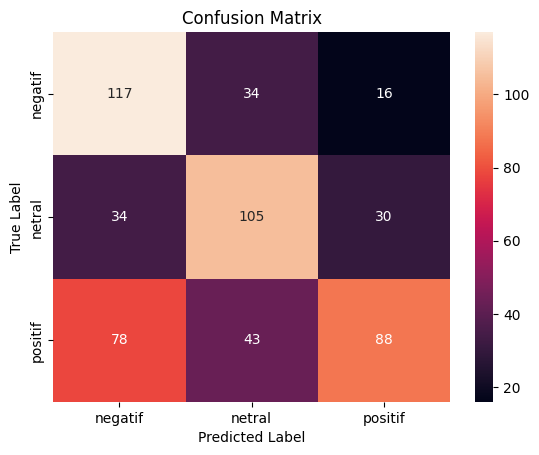

In [39]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Evaluation
#print('Best Hyperparameters:', best_params) # max_depth = 20, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 5, n_estimators = 300

# Membuat instance dari LabelEncoder
label_encoder = LabelEncoder()

# Mengubah label kelas menjadi angka berurutan
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)

# Menampilkan classification report dengan label angka
print(classification_report(y_test_encoded, y_pred_encoded))

# Confusion Matrix
class_labels = label_encoder.classes_
data_cm = pd.DataFrame(confusion_matrix(y_test_encoded, y_pred_encoded), index=class_labels, columns=class_labels)
sns.heatmap(data_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Kesimpulan

Beberapa kesimpulan yang dapat saya berikan dalam analisa ini :


Dari hasil analisa yang telah dilakukan menunjukan Sentimen penumpang terhadap maskapai British Airways menunjukan banyaknya penumpang memberikan feedback positif daripada negatif yaitu ...% feedback positif dan ...% feedback negatif.


Namun hasil analisa lainnya terlihat bahwa kata-kata yang sering muncul dalam feedback positif adalah "Ekonomi", "Jokowi", "Rakyat", dan "Gaji". Sementara itu, kata-kata yang sering muncul dalam feedback negatif adalah "Ekonomi", "Jokowi", "Prabowo", "Gaji", "Harga". Sehingga ini bisa menjadi perhatian kembali bagi tim bisnis untuk memperbaiki aspek - aspek dari feedback yang diberikan oleh penumpang